# 実践コンピュータビジョン

[実践 コンピュータビジョン](https://www.oreilly.co.jp/books/9784873116075/)  

演習ノート

# 2. 画像の局所記述子

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path    
import sys
sys.path.append("../")
from impro import impro,detection

## 2.1 Harrisコーナー記述子
### 1.2.1 画像と点を表示する

$I_x$、$I_y$をそれぞれx方向の微分、y方向の微分として次のような行列$M_I$を考える
$$
M_I=\begin{pmatrix}
I_x^2 & I_xI_y \\
I_xI_y & I_y^2 
\end{pmatrix}
$$

周辺ピクセルの影響も考えるため、ガウスフィルター$W$を畳み込む
$$
\overline{M_I}=W*M_I
$$
この$\overline{M_I}$の2つの固有値の大きさでコーナーを検出できる。  

#### なぜこれでコーナーが検出できるのか

ペンシルベニア州立大学コンピューターサイエンス学科の講義資料を参照

[Lecture 06: Corner Detection](https://www.cse.psu.edu/~rtc12/CSE486/lecture06.pdf)

#### コーナーとは

コーナーとは、明度$I(x,y)$が直交する2つの方向に移動したときに大きく変化する場所である。

明度の変化は次のように表せる
$$
E(u,v)=\sum_{x,y}{w(x,y)[I(x+u,y+v)-I(x,y)]^2}
$$

#### テイラー展開
テイラー展開によって2次元関数は次のように近似できる。$u$、$v$は微少だとする。
$$
f(x+u,y+v)=f(x,y)+uf_x+vf_y
$$

これを上に用いれば
$$
\begin{align}
[I(x+u,y+v)-I(x,y)]^2
&=[uI_x+vI_y]^2\\
&=u^2I_x^2+2uvI_xI_y+v^2I_y^2\\
&=
\begin{pmatrix}
u&v
\end{pmatrix}
\begin{pmatrix}
I_x^2 & I_xI_y \\
I_xI_y & I_y^2 
\end{pmatrix}
\begin{pmatrix}
u\\v
\end{pmatrix}\\
&=
\begin{pmatrix}
u&v
\end{pmatrix}
M_I
\begin{pmatrix}
u\\v
\end{pmatrix}
\end{align}
$$

#### 二次形式
↑の議論から若干飛躍してしまうが、明度変化$E$は次のように表せる。$M$は$M_I$と同様対称行列である。
$$
E(u,v)=\begin{pmatrix}
u&v
\end{pmatrix}
M
\begin{pmatrix}
u\\v
\end{pmatrix}
$$

これは二次形式である。二次形式についてはここを参照  
[二次形式の意味，微分，標準形など](https://manabitimes.jp/math/1240)

↑のサイトにも書いてある通り、対称行列は直交行列で対角化可能である。つまり$M$は直交行列$U$で
$$
UMU^T=
\begin{pmatrix}
\lambda_1 & 0 \\
0 & \lambda_2 \\
\end{pmatrix}
$$
と2つの固有値が対角に並んだ行列に対角化できる。  
つまり$\boldsymbol{x}=(u\ v)$で、$\boldsymbol{X}=U\boldsymbol{x}$と座標変換すると、
$$
\begin{align}
\boldsymbol{x}^TM\boldsymbol{x}&=
\boldsymbol{X}^T
\begin{pmatrix}
\lambda_1 & 0 \\
0 & \lambda_2 \\
\end{pmatrix}
\boldsymbol{X}\\
&=\sum_i{\lambda_iX_i^2}
\end{align}
$$

#### Harrisコーナー検出
つまり、元の座標から、$\boldsymbol{X}=U\boldsymbol{x}$と座標変換すれば、明度変化$E$は次のようになる。
$$
E(u,v)=\sum_i{\lambda_iX_i^2}
$$
これは$X_1$という方向に離れると$\lambda_1$だけ、そしてそれに直交する$X_2$という方向に離れると$\lambda_2$だけ明度が変化することを表す。  
よって2つの固有値$\lambda_1$と$\lambda_2$がどちらも大きい場合にコーナーと判断する。

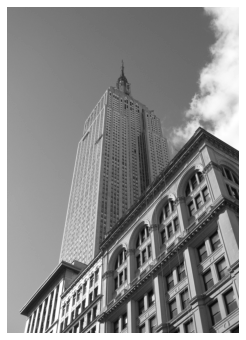

In [2]:
sigma=3
# 画像を読み込む
im_path=Path("resources/data/empire.jpg")
im=cv2.imread(str(im_path))
im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
impro.imshow(im_gray)

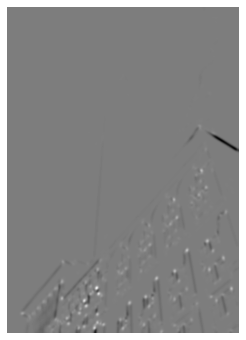

In [97]:
# 自作モジュールでHarris応答画像を計算
harrisim=detection.compute_harris_response(im_gray,sigma=3,k=0.06)
impro.imshow(harrisim,show_mode="scale")

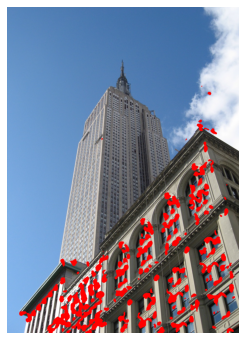

In [100]:
# 閾値を上回ったら着色
im_to_show=im.copy()
im_to_show[harrisim > harrisim.max()*0.01]=[0,0,255]
impro.imshow(im_to_show)

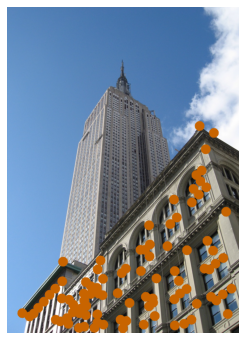

In [103]:
# 自作モジュールで実装したコーナー検索でコーナーを検索
coords=detection.search_harris_point(harrisim,min_dist=10,threshold=0.1)
detection.plot_harris_points(im,coords)

### OpenCVでの実装
http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html

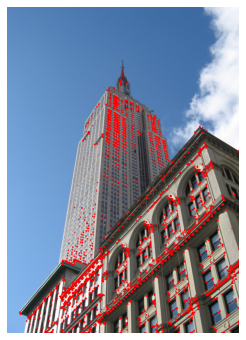

In [113]:
# cv2モジュールのcornerHarrisを使う
harrisim_cv2=cv2.cornerHarris(im_gray,2,3,0.04)

# 膨張処理
harrisim_cv2=cv2.dilate(harrisim_cv2,None)

# Threshold for an optimal value, it may vary depending on the image.
im_to_show=im.copy()
im_to_show[harrisim_cv2>0.01*harrisim_cv2.max()]=[0,0,255]
impro.imshow(im_to_show)

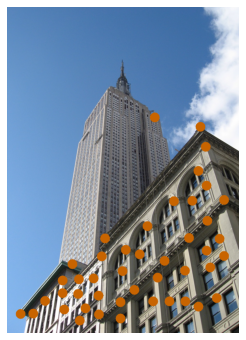

In [111]:
# 自作モジュールで実装したコーナー検索でコーナーを検索
coords=detection.search_harris_point(harrisim_cv2,min_dist=30,threshold=0.1)
detection.plot_harris_points(im,coords)

### 2.1.1 画像間の対応点を見つける
#### 教科書でのコード
教科書の内容をリファクタリング、コメントを加え、  
[detectionモジュール](../impro/detection.py)に実装済み

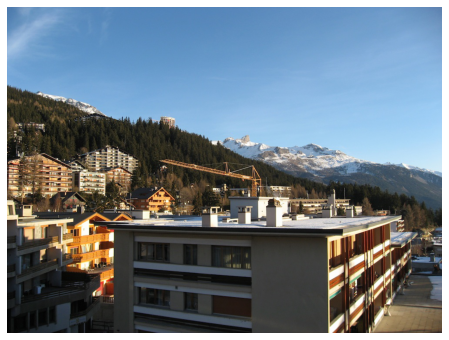

In [2]:
# 画像を読み込む
im1_path=Path("resources/data/crans_1_small.jpg")
im1=cv2.imread(str(im1_path))
im2_path=Path("resources/data/crans_2_small.jpg")
im2=cv2.imread(str(im2_path))
impro.imshow(im1)

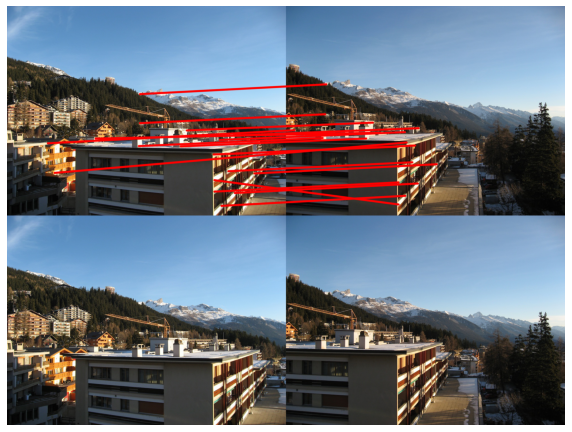

In [4]:
# 自作モジュールで実装した特徴点マッチングで結果を表示する
match_result=detection.draw_harris_ncc_match(im1,im2,min_dist=30)
impro.imshow(match_result,figsize=(10,15))

#### openCVを使った方法

openCVを用いた特徴点のマッチングを行う
- 特徴量記述子にHarrisではなく、AKAZE
- マッチングはフルスクラッチではなく、`cv2.BFMatcher`を用いる
- マッチング結果もフルスクラッチではなく`cv2.drawMatches`を用いる

以下の記事を参考にした
- [OpenCV: Feature Matching](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)
- [特徴点のマッチング — OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_feature2d/py_matcher/py_matcher.html)

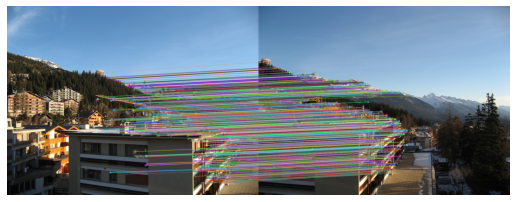

In [31]:
# A-KAZE検出器の生成
akaze = cv2.AKAZE_create()

# 特徴点とその特徴量ベクトルのリスト
kp1, des1 = akaze.detectAndCompute(im1,None)
kp2, des2 = akaze.detectAndCompute(im2,None)

# Brute-Force Matcher生成
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# 比較機で対応オブジェクトのリストmatchesを作成
matches = bf.match(des1, des2)
# 対応オブジェクトのメンバのdistanceでソートする
# sortedのkeyに無名関数(x.distanceを返す)を割り当ててソート
matches = sorted(matches, key = lambda x:x.distance)

# 許容最大の距離
threshold=0.3
max_dis=matches[-1].distance*threshold
matches_num=len(matches)
for i in range(matches_num):
    if matches[i].distance > max_dis:
        break
num_lim=i

img3 = cv2.drawMatches(im1, kp1, im2, kp2, matches[:num_lim], None, flags=2)

impro.imshow(img3)

### cv2.KeyPointオブジェクトについて
参考:https://docs.opencv.org/4.x/d2/d29/classcv_1_1KeyPoint.html  
- pt: 座標が入っている。(x,y)の順で、これはそれぞれnumpy.arrayの2次元目、1次元目となる
- angle: 角度 
- その他
        

### cv2.DMatchオブジェクトについて
参考:https://pystyle.info/opencv-feature-matching/  

上の記事によると、上記のコード内で、
```python
matches = bf.match(des1, des2)
```
と生成している`matches`の要素`cv2.DMatch`について、要素は以下のとおりである。
> - distance: 特徴量記述子の距離
> - queryIdx: クエリ記述子 (match(desc1, desc2) と渡した場合、desc1 のインデックス)
> - trainIdx: 学習記述子 (match(desc1, desc2) と渡した場合、desc2 のインデックス)

`matches`の最初のオブジェクトの属性を見てみると、

In [36]:
m = matches[0]

print(f"distance: {m.distance}, queryIdx: {m.queryIdx}, trainIdx: {m.trainIdx}")

distance: 4.0, queryIdx: 1106, trainIdx: 587


> これは im1 の特徴点 kp1[1106] と最も距離が近い im2 の特徴点は kp2[587] であることを表しています。 また、その2つの特徴点の特徴量記述子同士の距離が4であることを表しており、この距離が近いほど、2つの特徴点は似ていると解釈できます。

## 2.2 SIFT

SIFTは特許で保護されていたので、デフォルトのopenCVには含まれておらず、追加パッケージをインストールする必要があったが、2021年3月に期限切れになったので、普通に使えるようになった。

[SIFTの特許が切れてOpenCV v4.4.0から普通に使えるようになってた話 - Qiita](https://qiita.com/herr-shigeo/items/ec9abac4212628162598)

教科書では[Keypoint detector](https://www.cs.ubc.ca/~lowe/keypoints/)からバイナリを入手し、コマンド実行で使用しているが、この演習ではopenCVのSIFTを用いる。  


以下の記事を参考に、  

- [OpenCV: Feature Matching](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)
- [特徴点のマッチング — OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_feature2d/py_matcher/py_matcher.html)


自作モジュールの[detectionモジュール](../impro/detection.py)の`impro.detection.sift_matching`でSIFTによるマッチングができるようにした  
(SIFTよりAKAZEの方が性能がいいといわれているが、「3.3 パノラマの作成」で少し性能の悪い特徴量記述子が必要なのでSIFTも使う)

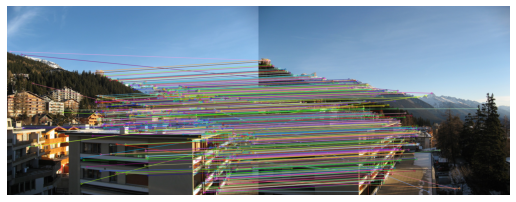

In [3]:
kp1,kp2,matches,img3=detection.sift_matching(im1,im2,draw_result=True)
impro.imshow(img3)